####Libraries



In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive

import os
from glob import glob
from PIL import Image
import shutil
import json

import cv2 as cv

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image

####Pre-processing

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [57]:
lesion_df = pd.read_csv('/content/drive/MyDrive/XAI/HAM10000_metadata.csv')

# Define the root directory for the images and the target directory in Google Drive
image_dir = '/content/drive/MyDrive/XAI/img'
target_dir = '/content/drive/MyDrive/XAI/org_img'

In [58]:
def find_image_path(image_id):
    # Check both directories
    for image_dir in [image_dir]:
        possible_path = os.path.join(image_dir, f'{image_id}.jpg')
        if os.path.exists(possible_path):
            return possible_path
    return None

# Update image_path column
lesion_df['image_path'] = lesion_df['image_id'].apply(lambda x: os.path.join(image_dir, f'{x}.jpg'))

print("Image paths updated in DataFrame:")
print(lesion_df[['image_id', 'image_path']].head())

Image paths updated in DataFrame:
       image_id                                       image_path
0  ISIC_0027419  /content/drive/MyDrive/XAI/img/ISIC_0027419.jpg
1  ISIC_0025030  /content/drive/MyDrive/XAI/img/ISIC_0025030.jpg
2  ISIC_0026769  /content/drive/MyDrive/XAI/img/ISIC_0026769.jpg
3  ISIC_0025661  /content/drive/MyDrive/XAI/img/ISIC_0025661.jpg
4  ISIC_0031633  /content/drive/MyDrive/XAI/img/ISIC_0031633.jpg


In [59]:
null_count = lesion_df['image_path'].isnull().sum()
print("Number of null values in 'image_path' column:", null_count)

Number of null values in 'image_path' column: 0


In [60]:
train_dir = '/content/drive/MyDrive/XAI/org_img'

# ImageDataGenerator for training and validation with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)


Found 83 images belonging to 7 classes.
Found 17 images belonging to 7 classes.


In [61]:
# Load your trained model
model1 = load_model('/content/drive/MyDrive/XAI/efficientnetv2b3_skin_lesion_model_final.h5')

####Predictions

In [62]:
import cv2

IMAGE_SIZE = 300

cancer_descriptions = {
    'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowen\'s disease',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas, and hemorrhage)'
}

def predict_cancer(image_path):
    img = keras_image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model1.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]
     # Check if predicted_index is within the valid range
    if predicted_index >= len(class_indices):
        return "Invalid Prediction", None, None, None

    predicted_label = list(class_indices.keys())[predicted_index]
    confidence = predictions[0][predicted_index]

    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))


    return predicted_label, confidence, img, original_image_array

image_path = '/content/ISIC_0024306.jpg'
predicted_label, confidence,img,original_image_array = predict_cancer(image_path)

print(f"Predicted cancer type: {predicted_label}")
print(f"Confidence: {confidence}")
if original_image_array is not None:
    print(f"Description: {cancer_descriptions[predicted_label]}")


1/1 [==============================] - 5s 5s/step
Predicted cancer type: nv
Confidence: 0.621322751045227


####Grad-CAM

1/1 [==============================] - 4s 4s/step


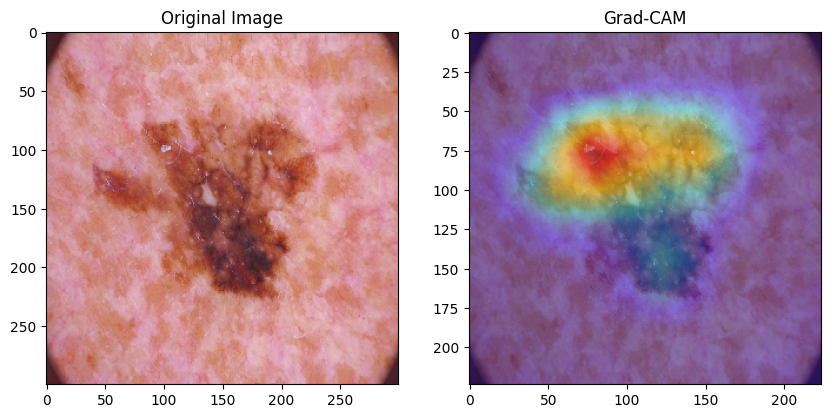

In [63]:
# Load the EfficientNetV2B3 model
model = EfficientNetV2B3(weights='imagenet')

# Define a function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, layer_name, class_idx):
    # Get the model output and the specified layer
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
        conv_output, predictions = iterate(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Load and preprocess the image
img_path = '/content/ISIC_0024310.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate heatmap
layer_name = 'top_conv'  # Replace with the appropriate layer name
class_idx = np.argmax(model.predict(img_array))  # Index of the predicted class
heatmap = generate_gradcam_heatmap(model, img_array, layer_name, class_idx)

# Load the original image
original_img = cv.imread(img_path)
original_img = cv.resize(original_img, (224, 224))  # Resize to the size of input image

# Resize heatmap to match original image size
heatmap_resized = cv.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Convert heatmap to 8-bit
heatmap_img = np.uint8(255 * heatmap_resized)

# Apply colormap and blend with original image
heatmap_img = cv.applyColorMap(heatmap_img, cv.COLORMAP_JET)
superimposed_img = cv.addWeighted(heatmap_img, 0.4, original_img, 0.6, 0)

# Display the image and Grad-CAM
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
cv.imwrite('heatmap_result.jpg', superimposed_img)
plt.imshow(cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB))
plt.title('Grad-CAM')

plt.show()


####Enhanced Grad-CAM

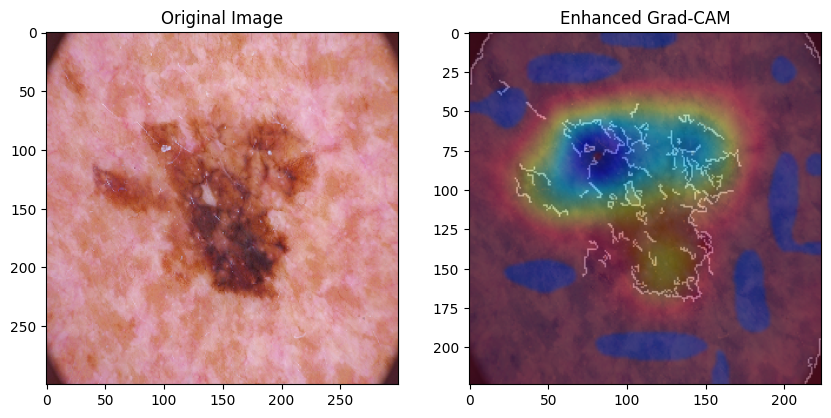

In [74]:
import cv2
def normalize_heatmap(heatmap):
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Normalize and resize heatmap
heatmap = normalize_heatmap(heatmap)  # Apply normalization
heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_CUBIC)

# Convert to 8-bit and apply colormap
heatmap_img = np.uint8(255 * heatmap_resized)
heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)

# Optionally smooth heatmap
heatmap_img = cv2.GaussianBlur(heatmap_img, (5, 5), 0)

# Blend with original image
superimposed_img = cv2.addWeighted(heatmap_img, 0.5, original_img, 0.5, 0)

# Optionally apply edge detection
edges = cv2.Canny(cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY), 100, 200)
edge_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
superimposed_img = cv2.addWeighted(superimposed_img, 0.7, edge_img, 0.3, 0)

# Display results

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Enhanced Grad-CAM')

plt.show()

####LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


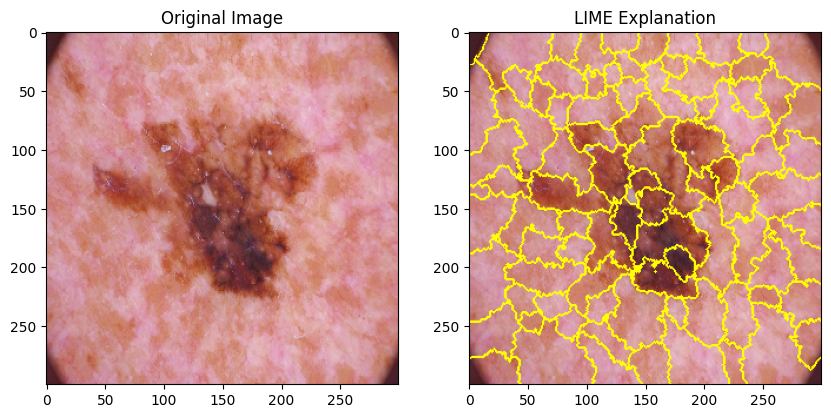

In [101]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image

# Define a function to preprocess the image
def preprocess_image(image_path, image_size=300):
    img = keras_image.load_img(image_path, target_size=(image_size, image_size))
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define the prediction function for LIME
def predict_fn(images):
    preds = model1.predict(images)
    return preds

# Load and preprocess sample image
image_path = '/content/ISIC_0024310.jpg'
img_array = preprocess_image(image_path)

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(img_array[0], predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Show explanation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_array[0])
ax[0].set_title('Original Image')
ax[1].imshow(mark_boundaries(img_array[0], explanation.segments))
ax[1].set_title('LIME Explanation')
plt.show()
